In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datareader
import RnPrConstructor

import warnings
warnings.simplefilter('ignore')

In [180]:

dr = datareader.DataReader('portfolio_optimize.json')

[*********************100%***********************]  259 of 259 completed

7 Failed downloads:
- COWN: No timezone found, symbol may be delisted
- MSGE: Data doesn't exist for startDate = 1583038800, endDate = 1677646800
- MCG: No timezone found, symbol may be delisted
- SRNE: No timezone found, symbol may be delisted
- LHDX: No timezone found, symbol may be delisted
- ONEM: No timezone found, symbol may be delisted
- VLDR: No timezone found, symbol may be delisted


In [181]:
data = dr.get_data()


In [198]:
class EfficientFrontier:
    
    def __init__ (self, data, risk_free_rate = 0.03):
        
        self.data = data
        self.risk_free_rate = risk_free_rate
        
        
        self.mean_ret = self.data.pct_change().fillna(0).mean()
        self.cov = self.data.pct_change().fillna(0).cov()
                
    def compute_annualized_performance(self,weights):
        
        P_ret = np.sum(self.mean_ret * weights.T).mean()
        P_vol =np.sqrt((weights.T @ np.dot(self.cov,weights)))*np.sqrt(252)
        
        return P_ret, P_vol

    
    def compute_sharpe(self, weights):
        #print(weights)
        P_ret = np.sum(self.mean_ret * weights)
        P_vol =np.sqrt((weights.T @ np.dot(self.cov,weights)))
        sharpe = (P_ret - self.risk_free_rate)/P_vol
        return sharpe
        
    def generate_randomizedPortfolios(self, num = 1000):
        portfolios = []
        
        for i in range(num):
            
            CW = RnPrConstructor.RnPrConstructor(self.data)
            CW.construct_weights()
            weights = CW.get_weights()
            annualized_perf = self.compute_annualized_performance(weights)
            portfolios.append([weights,annualized_perf[0],annualized_perf[1],self.compute_sharpe(weights)])
        portfolios = np.array(portfolios)
        return portfolios
    
    def plot_frontier(self, portfolios):
        plt.figure(figsize=(10, 7))

        max_sharpe_idx = np.argmax(portfolios[:,3])
        
        #print(portfolios[max_sharpe_idx,3])
              
        min_vol_idx = np.argmin(portfolios[:,2])
        plt.scatter(portfolios[:,2],portfolios[:,1],c=portfolios[:,3],
                    cmap='YlGnBu', marker='o', s=10, alpha=0.3)
        plt.scatter(portfolios[max_sharpe_idx,2],
                    portfolios[max_sharpe_idx,1],
                    marker='*',color='r',
                    s=500, label='Maximum Sharpe ratio')
        plt.colorbar()

        plt.scatter(portfolios[min_vol_idx,2],
                    portfolios[min_vol_idx,1],marker='*',color='g',s=500, label='Minimum volatility')
        plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
        plt.xlabel('annualised volatility')
        plt.ylabel('annualised returns')
        plt.legend(labelspacing=0.8)
        plt.legend()
        
    

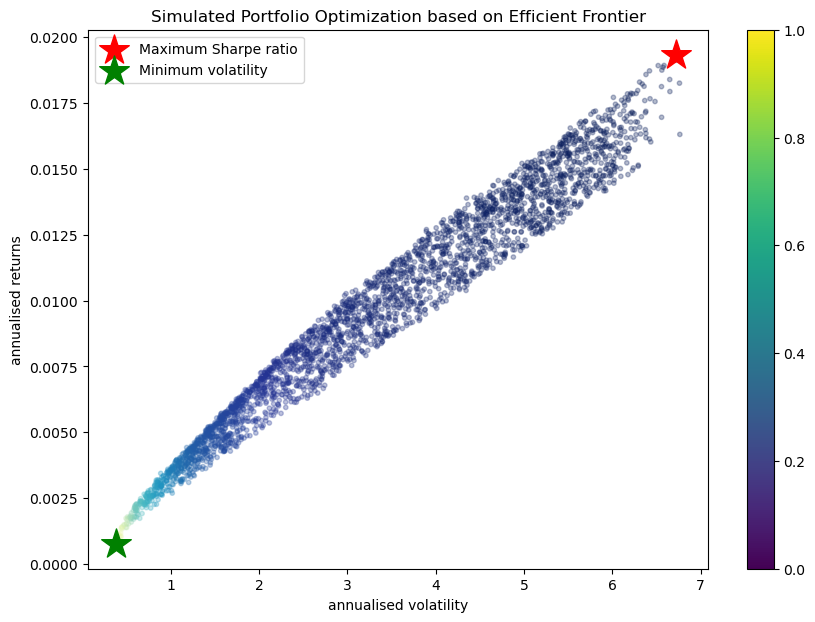

In [199]:
ef = EfficientFrontier(data)
prs = ef.generate_randomizedPortfolios(3000)
ef.plot_frontier(prs)
